In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os,sys
import sqlite3
from os.path import join
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
from scipy.stats import itemfreq
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
from scipy.sparse import csr_matrix
from tqdm import tqdm

### Get data
The data is all the news from visir.is, the urls to them are kept in the file urls_visir_dec18.txt.
We visit all the urls, which are about 280,000 and save the text. This runs pretty slowly on windows in notebook, but try running the file get_data.py to make this happen faster.

In [26]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import urllib
from lxml.html import fromstring

urls = open("urls_visir_dec18.txt","r").read().split("\n")
os.makedirs("article_texts",exist_ok=True)
def parse(i):
    url = urls[i]
    page = url.split('/')[-1]
    body = fromstring(urllib.request.urlopen(url).read())
    text = body.xpath("//*[contains(@class, 'article-single__content')]")[0].text_content().strip()
    header = body.xpath("//title")[0].text_content().strip()
    filename = join("article_texts",page)
    with open(filename+'.txt','w') as f:
        f.write(url+'\n')
        f.write(header)
        f.write('\n')
        f.write(text)
    return i

if "linux" in sys.platform: #because multiprocessing doesn't work in jupyter on windows
    pool = Pool(4)
    for i in pool.imap_unordered(parse,range(len(urls))):
        continue
else:
    for i in tqdm(range(len(urls))):
        parse(i)



Now we should have a folder named article_texts containing one .txt file for each url. We now read them all and create a .csv file. Then you can just delete the article_texts directory.

In [6]:

path = 'article_texts/'
files = os.listdir(path)
texts = []
headlines = []
urls = []
for k in tqdm(range(len(files))):
    f = files[k]
    try:
        lines = [i.decode("latin-1") for i in open(join(path,f),'rb').readlines()]
    except:
        continue
    lines = [i for i in lines if i != '']
    headline = lines[1].replace('\n','').replace("- Vísir","").strip()
    if headline == "":
        continue
    urls.append(lines[0].strip())
    headlines.append(headline)
    text = ''
    for i in lines[2:]:
        text = text + " " + i.lower().replace('\n','').strip()
    texts.append(text)

df = pd.DataFrame()
df["url"] = urls
df["headline"] = headlines
df["text"] = texts
df.to_csv("visir_texts.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 3350.88it/s]


Now we have all the data, let's build some models
The code is mostly taken from this tutorial http://brandonrose.org/clustering#Visualizing-document-clusters

In [8]:
csv_file = "visir_texts.csv" #load data

df = pd.read_csv(csv_file)
urls = df["url"]
headlines = df["headline"]
texts = df["text"]

if not os.path.isdir("experiments"):
    os.mkdir("experiments")
if not os.path.isdir(join("experiments",csv_file.replace(".csv",""))):
    os.mkdir(join("experiments",csv_file.replace(".csv","")))

save_folder = join("experiments",csv_file.replace(".csv","")) #where we save all results and models

def tokenize(txt):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(txt)


def most_common_words(texts,n):
    tokenizer = RegexpTokenizer(r'\w+')
    word_lists = []
    for i in tqdm(range(len(texts))):
        word_lists.append(tokenizer.tokenize(texts[i]))
    words = [x for n in word_lists for x in n]
    wf = Counter(words).most_common()
    return wf

if os.path.isfile(join(save_folder,"most_common.npy")):
    mc = np.load(join(save_folder,"most_common.npy"))
else:
    print("Finding most common words...")
    mc = most_common_words(texts[:20000],10)
    mc = np.array(mc)
    np.save(join(save_folder,"most_common.npy"),mc)

    

Finding most common words...


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 8577.31it/s]


Because the computations can take pretty long, we only do them the first time and save the models to disk, and after that we load the previously created models.

In [9]:
stop_words = mc[:20,0]
if os.path.isfile(join(save_folder,"vectorizer.pkl")):
    print("Loading tfidf matrix...")
    #tfidf_vectorizer = joblib.load(join(save_folder,"vectorizer.pkl"))
    tfidf_matrix = np.load(join(save_folder,"tfidf_matrix.npy"))
    terms = np.load(join(save_folder,"terms.npy"))
    try:
        tfidf_matrix = csr_matrix(tfidf_matrix.tolist()).todense()
    except:
        pass
else:
    print("Creating tfidf matrix...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                             min_df=0.01, stop_words = list(stop_words),
                             use_idf=True, tokenizer=tokenize, ngram_range=(1,3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    terms = tfidf_vectorizer.get_feature_names()
    np.save(join(save_folder,"tfidf_matrix.npy"),tfidf_matrix)
    joblib.dump(tfidf_vectorizer, join(save_folder,"vectorizer.pkl"))

Creating tfidf matrix...


In [18]:
n_clusters = 4

if os.path.isfile(join(save_folder,"km_%d_clusters.pkl"%n_clusters)):
    km = joblib.load(join(save_folder,"km_%d_clusters.pkl"%n_clusters))
    print("Loaded kmeans model")
else:
    print("Training kmeans model...")
    km = MiniBatchKMeans(n_clusters=n_clusters)
    km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
df["cluster"] = clusters
order_centroids = km.cluster_centers_.argsort()[:, ::-1]


Training kmeans model...


In [19]:
df["cluster"].value_counts()

2    53
0     9
3     8
1     7
Name: cluster, dtype: int64

In [21]:
print("Top terms per cluster:")
print()
for i in range(n_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :100]: #replace 6 with n words per cluster
        #if terms[ind] not in mc[0][:200]:
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print() #add whitespace

    print("Cluster %d headlines:" % i, end='')
    for headline in df[df["cluster"]==i]['headline'].values.tolist()[:20]:
        print(' %s,' % headline, end='')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: hún, öryggi, esb, eins sjá, sjá má, eins sjá má, árs, þjónustunnar, sjá, má, gæði, stakk, upp, 51 árs, verið, þar, þess, þegar, elísabet, 51, jean claude, claude, jean, tólf, eins, trump, ræða, svo, einnig, voru, þeirra, stakk upp nafninu, beckham, stakk upp, upp nafninu, jude, sjúklinga, twitter, njóta, upplifði, segir hún, sprengingarnar, boston, koma, helgina sextán þeirra, helgina sextán, tveir aldrei, þegar verið sviptir, tveir aldrei öðlast, öðlast ökuréttindi, þegar verið, teknir ölvunar, öðlast, verið sviptir ökuleyfi, 19 41 árs, höfuðborgarsvæðinu helgina, höfuðborgarsvæðinu helgina sextán, höfðu þegar, höfðu þegar verið, verið sviptir, ölvunar fíkniefnaakstur höfuðborgarsvæðinu, ölvunar fíkniefnaakstur, sex konur, ölvunar, sex konur 19, þessara ökumanna höfðu, þessara ökumanna, 19 41, tólf karla, fjórir þessara ökumanna, árs fjórir þessara, stöðvaðir reykjavík, stöðvaðir reykjavík einn, reykjavík einn kópavogi, reykjavík einn, 21 51, 2

c:\users\svee\anaconda3\envs\text_analysis\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


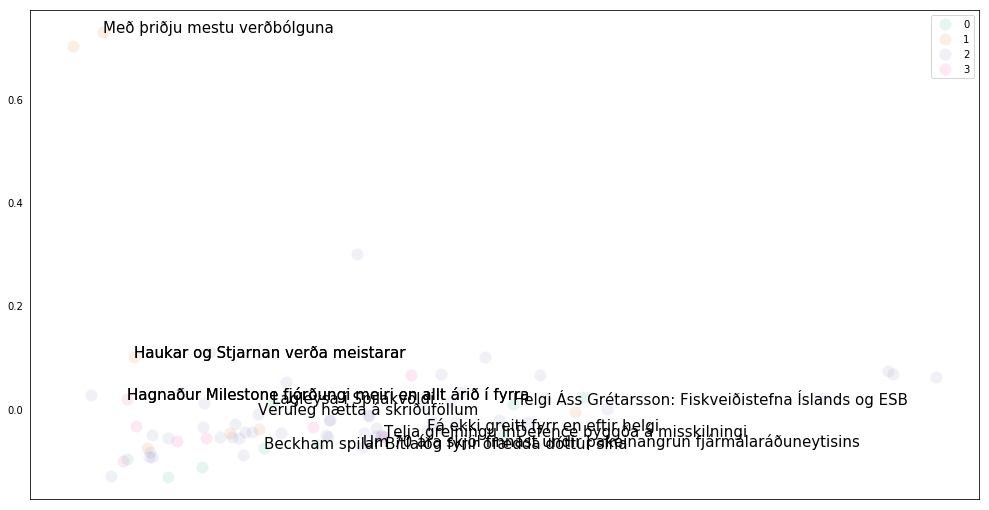

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

%matplotlib inline 

if os.path.isfile(join(save_folder,"pca.pkl")):
    pca = joblib.load(join(save_folder,"pca.pkl"))
else:
    pca = PCA(n_components=2)
    pca.fit(1-cosine_similarity(tfidf_matrix[:5000]))
    joblib.dump(pca,join(save_folder,"pca.pkl"))
    
def get_2d_pos(documents):
    d = 1-cosine_similarity(tfidf_matrix[:5000],documents)
    xy = pca.transform(d.T)
    return xy[:,0],xy[:,1]
    

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

n_samples = 1000

xs,ys = get_2d_pos(tfidf_matrix[:n_samples])
plot_df = pd.DataFrame(dict(x=xs, y=ys, cluster=clusters[:n_samples], headline=headlines[:n_samples])) 
groups = plot_df.groupby('cluster')


    
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=name, color=cluster_colors[name], 
            mec='none',alpha=0.1)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',)         # ticks along the top edge are off

ax.legend(numpoints=1)  #show legend with only 1 point

for i in range(n_clusters):
    cluster_df = plot_df[plot_df["cluster"]==i].reset_index()
    for j in np.random.choice(np.arange(len(cluster_df)),3):
        ax.text(cluster_df.loc[j]['x'], cluster_df.loc[j]['y'], cluster_df.loc[j]['headline'], size=15)  